In [1]:
import gpytorch

from bo_functions import best_error_advanced
from bo_functions import calc_ei_advanced
from bo_functions import LHS_Design
from bo_functions import create_y_data
from bo_functions import test_train_split
from bo_functions import ExactGPModel
from bo_functions import train_GP_model
from bo_functions import calc_GP_outputs
from bo_functions import calc_y_expected
from bo_functions import improvement

from bo_plotters import plotter_adv
from bo_plotters import y_plotter_adv
from bo_plotters import stdev_plotter_adv
from bo_plotters import ei_plotter_adv
from bo_plotters import improvement_plot

In [2]:
#Set noise parameters and load csv file to generate training data
noise_std = 0.1**2
all_p = LHS_Design("LHS_Toy_3_Input.csv")
all_y = create_y_data(all_p, noise_std)

#Separate training and testing data, uses default of an 80%/20% split
train_test_data = test_train_split(all_p,all_y)

train_p = train_test_data[0] #1x19
train_y = train_test_data[1] #1x19
test_p = train_test_data[2] #1x19
test_y = train_test_data[3] #1x19

In [3]:
# initialize likelihood and model
##Assumes a homoskedastic noise model p(y | f) = f + noise
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# We will use the simplest form of GP model, exact inference
#Defines our model in terms of the class parameters in bo_functions
model = ExactGPModel(train_p, train_y, likelihood)

In [4]:
#Set number of training iterations and train GP
iterations = 500
train_GP_model(model,likelihood, train_p, train_y, iterations)

In [5]:
# Get into evaluation (predictive posterior) mode
#Puts model in evaluation mode
model.eval()
#Puts likelihood in evaluation mode
likelihood.eval();

In [6]:
#Calculates GP outputs for mean, variance, standard devaition, and y output
GP_Outputs = calc_GP_outputs(model,likelihood,test_p)

model_mean = GP_Outputs[0] #1x6
model_variance= GP_Outputs[1] #1x6
model_stdev = GP_Outputs[2] #1x6
model_y = GP_Outputs[3] #1x6

#Calculates expected y
y_exp = calc_y_expected(test_p, noise_std) #1x6

In [7]:
#Calculates best_error and expected improvement
best_error = best_error_advanced(model_y, y_exp)[0] #Scaler
best_x = best_error_advanced(model_y, y_exp)[1] #1x3
ei = calc_ei_advanced(best_error,model_mean,model_variance, y_exp) #1x6
print("EI:",ei)

Lower bound is [ 2.46412644 -0.15557215  0.61420503 -1.59006383  0.73445874  0.59751588]
Upper bound is [ 2.61545146  0.          0.77036347 -1.44729631  0.89936282  0.76470282]
pdf upper is [0.01916062 0.39414364 0.33036326 0.11269277 0.30463122 0.33372061]
cdf upper is [0.99313262 0.43818514 0.73046008 0.05591021 0.7686654  0.72491849]
pdf lower is [0.01304655 0.39894228 0.29651174 0.13997774 0.26623783 0.29780281]
cdf lower is [0.99554452 0.5        0.77945784 0.07390698 0.81577028 0.77777574]
EI: [0.45053897 0.         0.42388273 1.25848333 0.58028415 0.37943219]


In [15]:
Integrand_values = improvement(best_error,model_mean,model_variance,y_exp)
print("Lower Improvement Integrand is \n",Integrand_values[0] )
print("Upper Improvement Integrand is \n",Integrand_values[1] )

Lower Improvement Integrand is 
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.40161486e-17 0.00000000e+00]
Upper Improvement Integrand is 
 [ 0.00000000e+00  0.00000000e+00 -2.98006229e-17  0.00000000e+00
  0.00000000e+00 -3.01034745e-17]


In [9]:
#Test calc_ei_adv (to compare with hand calcs)
import numpy as np
import torch
er_best = 3.0 #IF this changes to 2 the sign of the integrand changes
mu = torch.tensor([3])
y_exp2 = np.array([4])
pred_var = torch.tensor([1])
print("EI:",calc_ei_advanced(er_best,mu,pred_var,y_exp2))

Lower bound is [-0.73205081]
Upper bound is [2.73205081]
pdf upper is [0.30516956]
cdf upper is [0.23206878]
pdf lower is [0.00955215]
cdf lower is [0.99685293]
EI: [0.]


Improvement is [-4.9061744e-05]


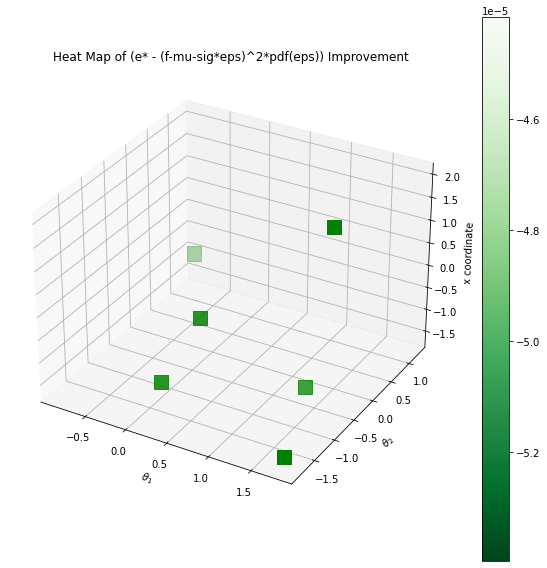

None


In [10]:
eps = -5
I = improvement(er_best,mu,pred_var,y_exp2,eps)
print("Improvement is", I)
print(improvement_plot(test_p,I))

Integrand: [array([-4.9061744e-05]), array([-0.00433576]), array([-0.09492421]), array([-0.40896157]), array([0.19838195]), array([0.9581426]), array([0.25421935]), array([-0.0013516]), array([-0.00110891]), array([-1.93273537e-05])]
Integrand Lower: [1.35522508e-16]
Integrand Upper: [4.24200538e-18]


Text(0, 0.5, 'Improvement Integrand')

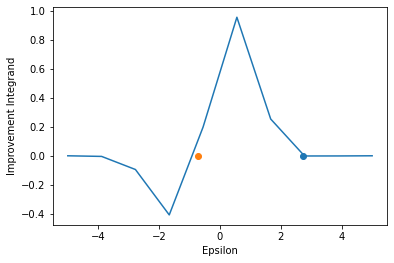

In [11]:
EPS = np.linspace(-5,5,10)
EPS_upper = ((y_exp2 - mu.numpy()) +np.sqrt(er_best))/np.sqrt(pred_var.numpy())
integrand_upper = improvement(er_best,mu,pred_var,y_exp2,EPS_upper)
EPS_lower = ((y_exp2 - mu.numpy()) -np.sqrt(er_best))/np.sqrt(pred_var.numpy())
integrand_lower = improvement(er_best,mu,pred_var,y_exp2,EPS_lower)

I_test = []
for i in range(len(EPS)):
    I_i = I = improvement(er_best,mu,pred_var,y_exp2,EPS[i])
    I_test.append(I_i)
print("Integrand:", I_test) 
print("Integrand Lower:",integrand_lower )
print("Integrand Upper:",integrand_upper )

from matplotlib import pyplot as plt    
plt.plot(EPS,I_test)
plt.scatter(EPS_upper,integrand_upper)
plt.scatter(EPS_lower,integrand_lower)
plt.xlabel("Epsilon")
plt.ylabel("Improvement Integrand")

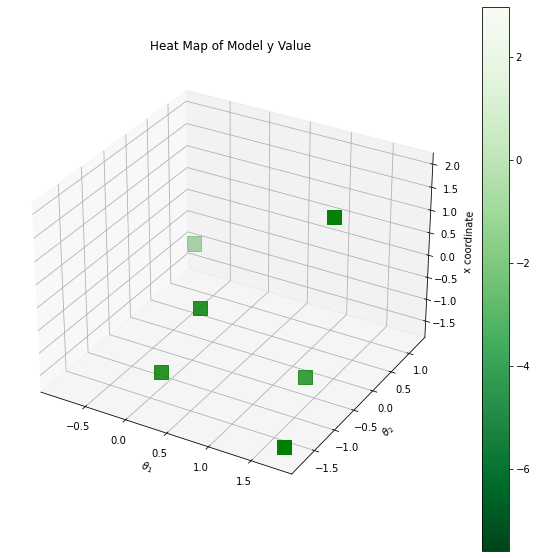

None


In [12]:
y_title = "Model y Value"
print(y_plotter_adv(test_p, model_y, y_title))

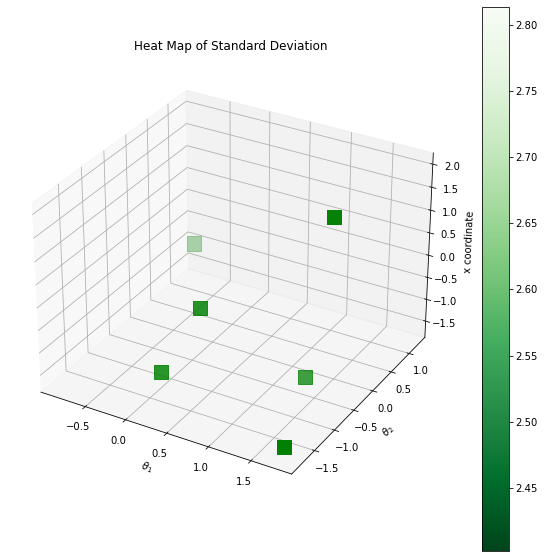

None


In [13]:
print(stdev_plotter_adv(test_p, model_stdev))

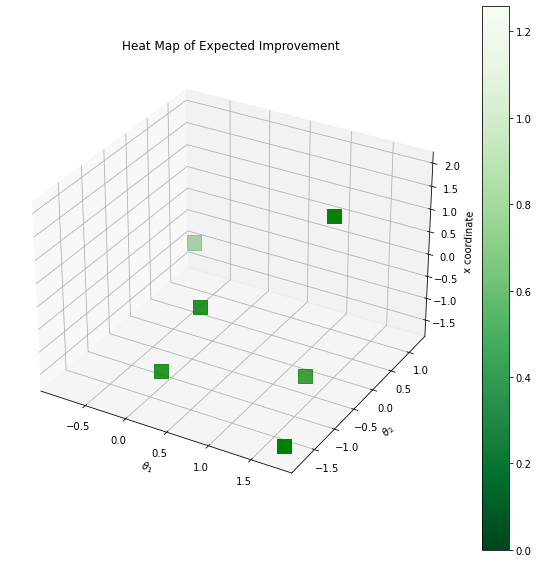

None


In [14]:
print(ei_plotter_adv(test_p, ei))